# Experiment
In this part of our project, we focused on Convolutional Neural Networks (CNNs). Following information is taken from the corresponding assignment's website: https://cs.uwaterloo.ca/~ppoupart/teaching/cs480-fall20/assignments.html.

In this assignment, you will experiment with fully connected neural networks and convolutional neural networks, using the Keras open source package. Keras is one of the simplest deep learning packages that serves as a wrapper on top of TensorFlow. Preliminary steps:

- Familiarize yourself with Keras. Click on "Guides" and read the first two guides: "The functional API" and "The Sequential Model".
- Download and install Keras on a machine with a GPU or use Google's Colaboratory environment, which allows you to run Keras code on a GPU in the cloud. Colab already has Keras pre-installed. To enable GPU acceleration, click on "edit", then "notebook settings" and select "GPU" for hardware acceleration. It is also possible to select "TPU", but the Keras code provided with this assignment will need to be modified in a non-trivial way to take advantage of TPU acceleration.
- Download the base code for this assignment: assignment jupyter file\footnote{https://cs.uwaterloo.ca/~ppoupart/teaching/cs480-fall20/assignments/asst4/cs480\_fall20\_asst4\_cnn\_cifar10.ipynb}.

Answer the following questions by modifying the base code in assignment jupyter file. Submit the modified Jupyter notebook via LEARN.

In [1]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
scores = saved_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
______________________________________________

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

10000/10000 [==============================] - 8s 844us/step
Test accuracy: 0.7397000193595886


In [2]:
#Results of the Convolutional NN
acc, val, saved, scores = history.history['accuracy'], history.history['val_accuracy'], saved_model, scores

Original Convolutional Neural Networks results are stored with the above variables to make it comparable to other experiments. We created a function out of the original code to take takes the trained model as a parameter and create training accuracy per epoch plot for that model. We found necessary to define the function since it's repeatedly used throughout this experiment. This function also returns the training accuracy, validation accuracy, saved best model and prediction scores.

In [3]:
def resulting(model0):
    # create a callback that will save the best model while training
    save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    # train without data augmentation
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model0.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_validate, y_validate),
                            shuffle=True,
                            callbacks=[save_best_model])

    # train with data augmentation
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history = model0.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                            epochs=epochs,
                            validation_data=(x_validate, y_validate),
                            callbacks=[save_best_model])

    # Plot training accuracy
    plt.plot(history.history['accuracy'])
    plt.title('training accuracy')
    plt.ylabel('training accuracy')
    plt.xlabel('epoch')
    plt.legend(['Conv'], loc='upper left')
    plt.show()

    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'])
    plt.title('validation accuracy')
    plt.ylabel('validation accuracy')
    plt.xlabel('epoch')
    plt.legend(['Conv'], loc='upper left')
    plt.show()

    # Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
    saved_model = load_model('best_model.h5')
    scores = saved_model.evaluate(x_test, y_test, verbose=1)
    print('Test accuracy:', scores[1])
    return history.history['accuracy'], history.history['val_accuracy'], saved_model, scores

**Part 1 (3 points)**: Compare the accuracy of the convolutional neural network in the file assignment jupyter file on the cifar10 dataset to the accuracy of simple dense neural networks with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units each. Run the code in the file assignment jupyter file without changing the parameters to train a convolutional neural networks. Then, modify the code in assignment jupyter file to obtain simple dense neural networks with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units (with a dropout rate of 0.5). Produce two graphs that contain 6 curves (one for the convolutional neural net and one for each dense neural net of 0-4 hidden layers). The y-axis is the accuracy and the x-axis is the number of epochs (\# of passes through the training set). Since neural networks take a while to train, cross-validation is not practical. Instead, produce one graph where all the curves correspond to the training accuracy and a second graph where all the curves correspond to the validation accuracy. Train the neural networks for 20 epochs. Although 20 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Among the models abtained after each epoch, save the model that achieves the best validation accuracy and report its test accuracy. Save the following results in your Jupyter notebook:
    
- The two graphs for training and validation accuracy.
- For each architecture, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per network architecture).
- Add some text to the Jupyter notebook to explain the results (i.e., why some models perform better or worse than other models).
    

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 4s 101us/step - loss: 2.2497 - accuracy: 0.2069 - val_loss: 1.9287 - val_accuracy: 0.3220

Epoch 00001: val_accuracy improved from -inf to 0.32200, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 3s 87us/step - loss: 2.0792 - accuracy: 0.2637 - val_loss: 1.8788 - val_accuracy: 0.3379

Epoch 00002: val_accuracy improved from 0.32200 to 0.33790, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 3s 85us/step - loss: 2.0223 - accuracy: 0.2882 - val_loss: 1.8733 - val_accuracy: 0.3500

Epoch 00003: val_accuracy improved from 0.33790 to 0.35000, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 4s 93us/step - loss: 1.9837 - accuracy: 0.3068 - val_loss: 1.8431 - val_accuracy: 0.3601

Epoch 00004: val_accuracy improved from 0.35000 to 0.36010, s

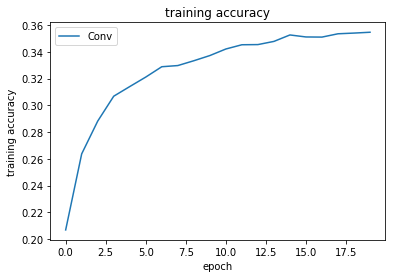

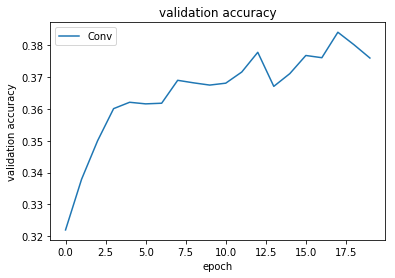

10000/10000 [==============================] - 0s 42us/step
Test accuracy: 0.3853999972343445
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30730     
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
#Part 1 - comparison of CNN model with simple dense NNs.
#0 hidden layers
model0 = Sequential()
model0.add(Flatten())
model0.add(Dropout(0.5))
model0.add(Dense(num_classes))
model0.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc0, val0, saved0, scores0 =  resulting(model0)
print(model0.summary())

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 17s 427us/step - loss: 1.9952 - accuracy: 0.2800 - val_loss: 1.8199 - val_accuracy: 0.3583

Epoch 00001: val_accuracy improved from -inf to 0.35830, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 17s 419us/step - loss: 1.8361 - accuracy: 0.3447 - val_loss: 1.7927 - val_accuracy: 0.3497

Epoch 00002: val_accuracy did not improve from 0.35830
Epoch 3/20
40000/40000 [==============================] - 16s 411us/step - loss: 1.7828 - accuracy: 0.3641 - val_loss: 1.7000 - val_accuracy: 0.4074

Epoch 00003: val_accuracy improved from 0.35830 to 0.40740, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 17s 414us/step - loss: 1.7419 - accuracy: 0.3806 - val_loss: 1.6659 - val_accuracy: 0.4193

Epoch 00004: val_accuracy improved from 0.40740 to 0.41930, saving model to best_model.h5

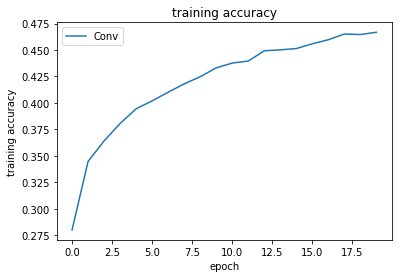

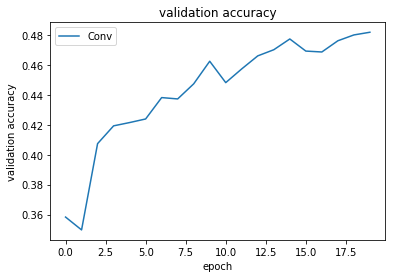

10000/10000 [==============================] - 1s 81us/step
Test accuracy: 0.478300005197525
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
Total params: 1,578,506
Tra

In [5]:
#1 hidden layer with 512 RelU units
model1 = Sequential()
model1.add(Flatten())
#1st hidden layer
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
#output layer
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc1, val1, saved1, scores1 =  resulting(model1)
print(model1.summary())

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 20s 508us/step - loss: 2.0763 - accuracy: 0.2358 - val_loss: 1.8796 - val_accuracy: 0.3270

Epoch 00001: val_accuracy improved from -inf to 0.32700, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 20s 495us/step - loss: 1.9143 - accuracy: 0.3040 - val_loss: 1.8099 - val_accuracy: 0.3593

Epoch 00002: val_accuracy improved from 0.32700 to 0.35930, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 20s 491us/step - loss: 1.8570 - accuracy: 0.3323 - val_loss: 1.7626 - val_accuracy: 0.3763

Epoch 00003: val_accuracy improved from 0.35930 to 0.37630, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 20s 501us/step - loss: 1.8147 - accuracy: 0.3456 - val_loss: 1.7268 - val_accuracy: 0.3875

Epoch 00004: val_accuracy improved from 0.37630 to 0.3

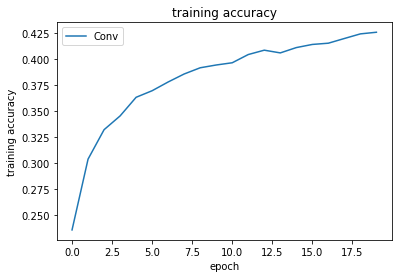

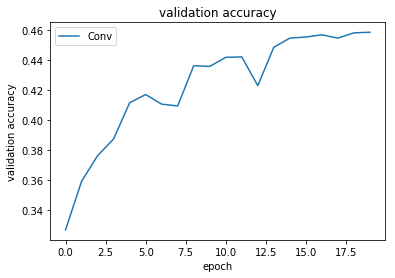

10000/10000 [==============================] - 1s 101us/step
Test accuracy: 0.45739999413490295
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
________________________

In [6]:
#2 hidden layers with 512 RelU units
model2 = Sequential()
model2.add(Flatten())
#1st layer
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
#2nd layer
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
#output layer
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc2, val2, saved2, scores2 =  resulting(model2)
print(model2.summary())

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 23s 581us/step - loss: 2.1588 - accuracy: 0.1868 - val_loss: 1.9474 - val_accuracy: 0.3043

Epoch 00001: val_accuracy improved from -inf to 0.30430, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 23s 570us/step - loss: 1.9775 - accuracy: 0.2689 - val_loss: 1.8616 - val_accuracy: 0.3379

Epoch 00002: val_accuracy improved from 0.30430 to 0.33790, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 23s 579us/step - loss: 1.9171 - accuracy: 0.3014 - val_loss: 1.8393 - val_accuracy: 0.3439

Epoch 00003: val_accuracy improved from 0.33790 to 0.34390, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 23s 571us/step - loss: 1.8811 - accuracy: 0.3165 - val_loss: 1.7864 - val_accuracy: 0.3733

Epoch 00004: val_accuracy improved from 0.34390 to 0.3

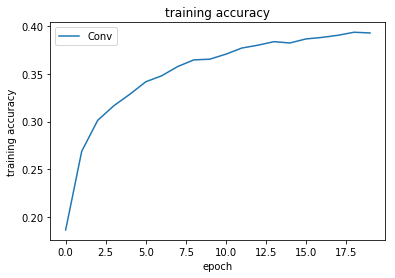

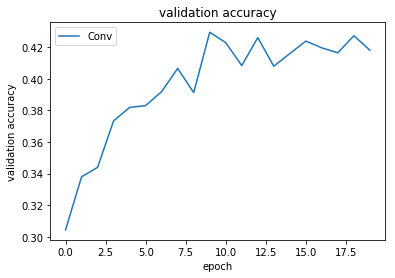

10000/10000 [==============================] - 1s 143us/step
Test accuracy: 0.429500013589859
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
__________________________

In [7]:
#3 hidden layers with 512 RelU units
model3 = Sequential()
model3.add(Flatten())
#1st hidden layer
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
#2nd hidden layer
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
#3rd hidden layer
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
#output layer
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc3, val3, saved3, scores3 =  resulting(model3)
print(model3.summary())

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 26s 652us/step - loss: 2.2297 - accuracy: 0.1478 - val_loss: 2.0539 - val_accuracy: 0.2297

Epoch 00001: val_accuracy improved from -inf to 0.22970, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 25s 631us/step - loss: 2.0509 - accuracy: 0.2197 - val_loss: 1.9435 - val_accuracy: 0.2833

Epoch 00002: val_accuracy improved from 0.22970 to 0.28330, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 26s 647us/step - loss: 1.9748 - accuracy: 0.2641 - val_loss: 1.8800 - val_accuracy: 0.3124

Epoch 00003: val_accuracy improved from 0.28330 to 0.31240, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 26s 644us/step - loss: 1.9409 - accuracy: 0.2814 - val_loss: 1.8518 - val_accuracy: 0.3371

Epoch 00004: val_accuracy improved from 0.31240 to 0.3

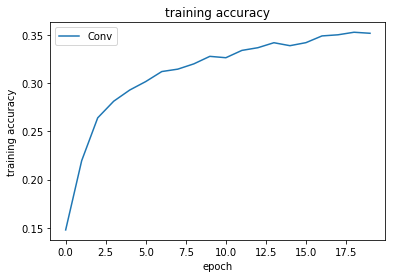

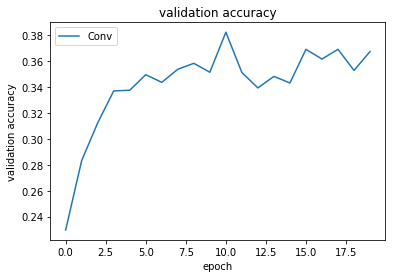

10000/10000 [==============================] - 1s 128us/step
Test accuracy: 0.38359999656677246
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1573376   
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
________________________

In [8]:
#4 hidden layers with 512 RelU units
model4 = Sequential()
model4.add(Flatten())
#1st hidden layer
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
#2nd hidden layer
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
#3rd hidden layer
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
#4th hidden layer
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
#output layer
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc4, val4, saved4, scores4 =  resulting(model4)
print(model4.summary())

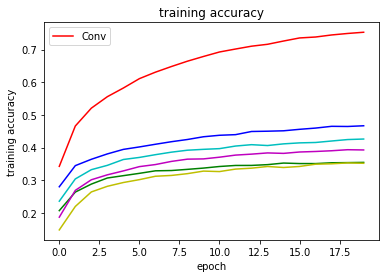

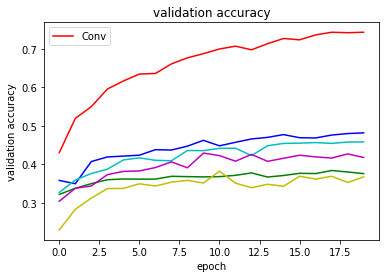

In [13]:
accs = [acc, acc0, acc1, acc2, acc3, acc4]
vals = [val, val0, val1, val2, val3, val4]
cols = ["r", "g", "b", "c", "m", "y"]
# Plot training accuracy
for a,i in zip(accs, range(6)): plt.plot(a, c=cols[i])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
# Plot validation accuracy
for v,j in zip(vals, range(6)): plt.plot(v, c=cols[j])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
#Red is CNN, green is 0 hidden layers, blue is 1 hidden layer, cyan is 2 hidden layers, magenta is 3 hidden layers and yellow is 4 hidden layers

The Convulitonal NN model outperforms simple dense NN models on both training and validation accuracy. In addition to that, our experiment resulted with NN with 1 hidden layer performed slightly better than any other simple NN models. It suggests, increasing the number of dense layers does not improve accuracy in short term, 20 epochs. Following  the 1 hidden layer simple NN, 3rd best performance is the 2 hidden layers simple NN. Following results are; 3 hidden layers simple NN, 0 hidden layer simple NN and the worst performance is the most complex model, 4 hidden layers simple NN. This can be the result of the complexity of the model, 4 dense layers, might resulted with the loss of the important features through the training process.

**Part 2 (1 point)**: Compare the accuracy achieved by rectified linear units and sigmoid units in the convolutional neural network in assignment jupyter file. Modify the code in assignment jupyter file to use sigmoid units. Produce two graphs (one for training accuracy and one for validation accuracy) that each contain 2 curves (one for rectified linear units and another one for sigmoid units). The y-axis is the accuracy and the x-axis is the number of epochs. Train the neural networks for 20 epochs. Although 20 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Save the following results in your Jupyter notebook:
    
- The two graphs for training and validation accuracy.
- For each activation function, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per activation function).
- Add some text to the Jupyter notebook to explain the results (i.e., why one model performs better or worse than the other model).

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 109s 3ms/step - loss: 2.3338 - accuracy: 0.1017 - val_loss: 2.3080 - val_accuracy: 0.0997

Epoch 00001: val_accuracy improved from -inf to 0.09970, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 110s 3ms/step - loss: 2.3074 - accuracy: 0.0983 - val_loss: 2.3033 - val_accuracy: 0.1014

Epoch 00002: val_accuracy improved from 0.09970 to 0.10140, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 120s 3ms/step - loss: 2.3061 - accuracy: 0.0996 - val_loss: 2.3035 - val_accuracy: 0.0952

Epoch 00003: val_accuracy did not improve from 0.10140
Epoch 4/20
40000/40000 [==============================] - 119s 3ms/step - loss: 2.3049 - accuracy: 0.0978 - val_loss: 2.3027 - val_accuracy: 0.1014

Epoch 00004: val_accuracy did not improve from 0.10140
Epoch 5/20
40000/40000 [==============

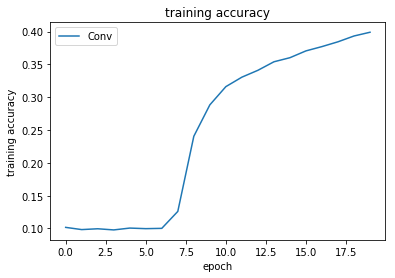

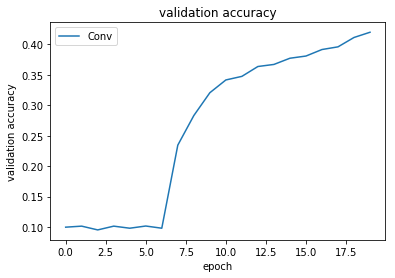

10000/10000 [==============================] - 8s 818us/step
Test accuracy: 0.42820000648498535
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_40 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 32)        0         
_______________________

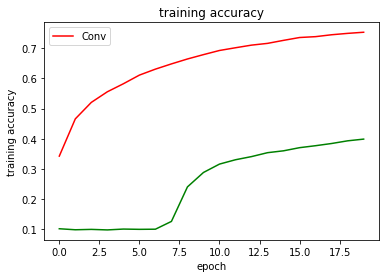

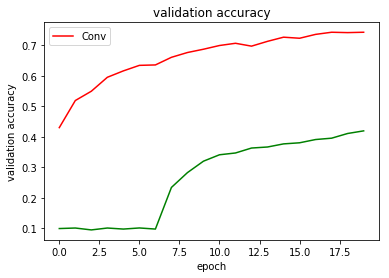

In [17]:
#Part 2 - 1st model vs 1st model with sigmoid function
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model5.add(Activation('sigmoid'))
model5.add(Conv2D(32, (3, 3), padding='same'))
model5.add(Activation('sigmoid'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Conv2D(64, (3, 3), padding='same'))
model5.add(Activation('sigmoid'))
model5.add(Conv2D(64, (3, 3), padding='same'))
model5.add(Activation('sigmoid'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Flatten())
model5.add(Dense(512))
model5.add(Activation('sigmoid'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes))
model5.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model5.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc5, val5, saved5, scores5 =  resulting(model5)
print(model5.summary())

# Plot training accuracy
plt.plot(acc, c="r")
plt.plot(acc5, c="g")
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
# Plot validation accuracy
plt.plot(val, c="r")
plt.plot(val5, c="g")
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
#Red is original CNN (with relu) and green is CNN with sigmoid

These two graphs above shows the training and validation accuracy scores for the original Convolutional NN, and a new model based on the same layer structure with the original Convolutional NN only the activation function for the hidden layers changed to sigmoid function intead of relu. The red plot is the original CNN and the green plot is the sigmoid modification. Accuracy scores suggest that original CNN has better start to the training and better overall result on 20 epochs. At the end of 20 epochs; original CNN has %72 accuracy and sigmoid modification has %41 accuracy. But the interesting point here is sigmoid modification's accuracy does not increase up to 6 epochs. Than it starts to increase with an exponential fashion, and at the end of 20 epochs there might still be a room to improve for the model. It is clear that the original CNN with relu activations on hidden layers performed better than sigmoid modification, however; the number of epochs should be increased to see which model performs better when they reach convergence. To stay in the scope of the assignment and with consideration of long training times, we will leave this experiment as a future work.

**Part 3 (2 points)**: Compare the accuracy achieved with and without drop out as well as with and without data augmentation in the convolutional neural network in assignment jupyter file. Modify the code in assignment jupyter file to turn on and off dropout as well as data augmentation. Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 4 curves (dropout with data augmentation, dropout with no data augmentation, no dropout with data augmentation, no dropout with no data augmentation). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for as many epochs as you can up to 100 epochs. No marks will be deducted for doing less than 100 epochs, however make sure to explain what you expect to see in the curves as the number of epochs reaches 100.
- The two graphs for training and validation accuracy.
- For each combination of dropout and data augmentation, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per combination of dropout and data augmentation).
- Add some text to the Jupyter notebook to explain the results (i.e., why did some models perform better or worse than other models and are the results consistent with the theory).

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 92s 2ms/step - loss: 1.6649 - accuracy: 0.4052 - val_loss: 1.4361 - val_accuracy: 0.4917

Epoch 00001: val_accuracy improved from -inf to 0.49170, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 95s 2ms/step - loss: 1.3295 - accuracy: 0.5273 - val_loss: 1.2765 - val_accuracy: 0.5482

Epoch 00002: val_accuracy improved from 0.49170 to 0.54820, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 97s 2ms/step - loss: 1.1718 - accuracy: 0.5860 - val_loss: 1.1337 - val_accuracy: 0.6049

Epoch 00003: val_accuracy improved from 0.54820 to 0.60490, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 98s 2ms/step - loss: 1.0527 - accuracy: 0.6327 - val_loss: 1.0445 - val_accuracy: 0.6356

Epoch 00004: val_accuracy improved from 0.60490 to 0.63560, sa

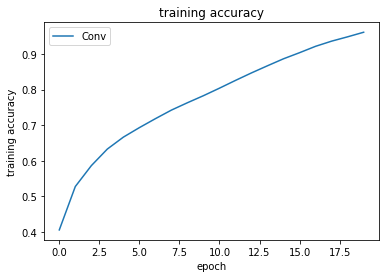

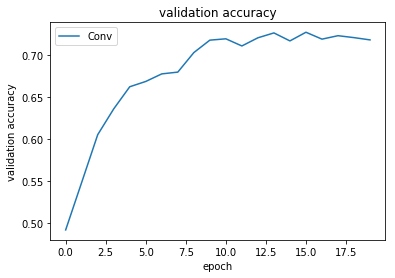

10000/10000 [==============================] - 8s 797us/step
Test accuracy: 0.7167999744415283
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_76 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_77 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)        18496     
________________________

In [23]:
#Part 3 - Dropout and data augmentation altered
#1st model has both dropout and data augmentation
#2nd model here, does not have dropout and data augmentation
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model6.add(Activation('relu'))
model6.add(Conv2D(32, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Conv2D(64, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(Conv2D(64, (3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Flatten())
model6.add(Dense(512))
model6.add(Activation('relu'))
model6.add(Dense(num_classes))
model6.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model6.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc6, val6, saved6, scores6 =  resulting(model6)
print(model6.summary())

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 97s 2ms/step - loss: 1.8279 - accuracy: 0.3351 - val_loss: 1.5396 - val_accuracy: 0.4539

Epoch 00001: val_accuracy improved from -inf to 0.45390, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 96s 2ms/step - loss: 1.4922 - accuracy: 0.4618 - val_loss: 1.3531 - val_accuracy: 0.5189

Epoch 00002: val_accuracy improved from 0.45390 to 0.51890, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 98s 2ms/step - loss: 1.3392 - accuracy: 0.5202 - val_loss: 1.2399 - val_accuracy: 0.5619

Epoch 00003: val_accuracy improved from 0.51890 to 0.56190, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 97s 2ms/step - loss: 1.2362 - accuracy: 0.5599 - val_loss: 1.1408 - val_accuracy: 0.6002

Epoch 00004: val_accuracy improved from 0.56190 to 0.60020, sa

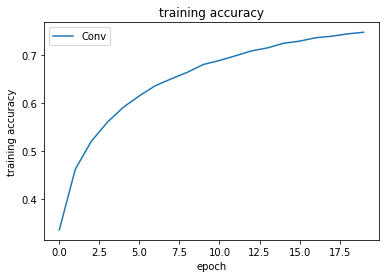

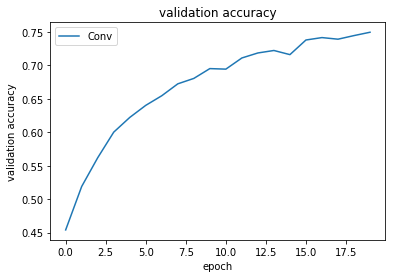

10000/10000 [==============================] - 8s 849us/step
Test accuracy: 0.7423999905586243
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_82 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_83 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 16, 16, 32)        0         
________________________

In [24]:
#3rd model with dropout but no data augmentation
model7 = Sequential()
model7.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model7.add(Activation('relu'))
model7.add(Conv2D(32, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.25))
model7.add(Conv2D(64, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(Conv2D(64, (3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.25))
model7.add(Flatten())
model7.add(Dense(512))
model7.add(Activation('relu'))
model7.add(Dropout(0.5))
model7.add(Dense(num_classes))
model7.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model7.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc7, val7, saved7, scores7 =  resulting(model7)
print(model7.summary())

Using real-time data augmentation.
Epoch 1/20
1250/1250 [==============================] - 102s 81ms/step - loss: 1.7120 - accuracy: 0.3846 - val_loss: 1.4585 - val_accuracy: 0.4820

Epoch 00001: val_accuracy improved from -inf to 0.48200, saving model to best_model.h5
Epoch 2/20
1250/1250 [==============================] - 100s 80ms/step - loss: 1.4354 - accuracy: 0.4857 - val_loss: 1.2727 - val_accuracy: 0.5484

Epoch 00002: val_accuracy improved from 0.48200 to 0.54840, saving model to best_model.h5
Epoch 3/20
1250/1250 [==============================] - 105s 84ms/step - loss: 1.3044 - accuracy: 0.5366 - val_loss: 1.1734 - val_accuracy: 0.5812

Epoch 00003: val_accuracy improved from 0.54840 to 0.58120, saving model to best_model.h5
Epoch 4/20
1250/1250 [==============================] - 102s 81ms/step - loss: 1.1996 - accuracy: 0.5762 - val_loss: 1.0815 - val_accuracy: 0.6184

Epoch 00004: val_accuracy improved from 0.58120 to 0.61840, saving model to best_model.h5
Epoch 5/20
1250/

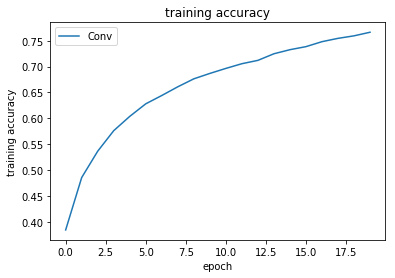

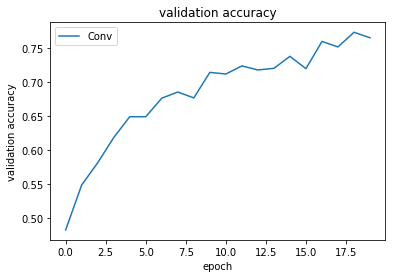

10000/10000 [==============================] - 8s 803us/step
Test accuracy: 0.7638000249862671
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_91 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_92 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 16, 16, 64)        18496     
________________________

In [26]:
#4th model does not have dropout but has data augmentation
data_augmentation = True

model8 = Sequential()
model8.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model8.add(Activation('relu'))
model8.add(Conv2D(32, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Conv2D(64, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(Conv2D(64, (3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Flatten())
model8.add(Dense(512))
model8.add(Activation('relu'))
model8.add(Dense(num_classes))
model8.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model8.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc8, val8, saved8, scores8 =  resulting(model8)
print(model8.summary())

data_augmentation = False

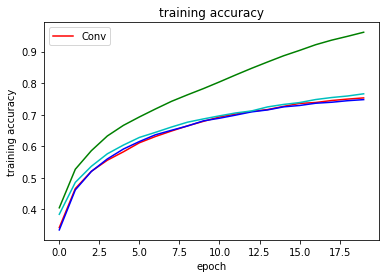

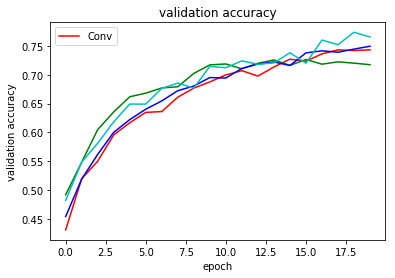

In [27]:
accs = [acc, acc6, acc7, acc8]
vals = [val, val6, val7, val8]
cols = ["r", "g", "b", "c"]
# Plot training accuracy
for a,i in zip(accs, range(4)): plt.plot(a, c=cols[i])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
# Plot validation accuracy
for v,j in zip(vals, range(4)): plt.plot(v, c=cols[j])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
#Red is original CNN, green is CNN with no dropout no data augmention
#Blue is CNN with dropout but no data augmention
#Cyan is CNN with data augmentation but no dropout

In this part we are comparing 4 different CNN models. First one is the original CNN represented with red color on both graphs, this model has both dropout and data augmentation implemented in. Second model is the green color, this model is the exact copy of the original CNN structure and modified to have neither dropout nor data augmentation. Third model is blue color in the graph and is modified to have dropout but no data augmentation. Fourth and last model is the cyan color and this model is modified to have data augmentation but no dropout. For convenience, these models are represented with the names CNN, CNNnone, CNNdrop, CNNaug respectively. For this experiment, training accuracy and validation accuracy plots does shows some differences and we should emphasize them. The CNNaug outperformed every other model on training accuracy with %20 difference. Other three models scored very similarly on training, as the above plot shows it is hard to distingiush the difference between them. On validation accuracy, our comparison suggests that the best performer is CNNnone. We should state that the validation accuracy for all models resulted very similarly and 20 epochs are not sufficient for the model to perform its best. Therefore it is not easy to interpret which model would perform the best, however it seems that all models follow a similar learning trend. All in all, in complicated models the effect of dropout and data augmentation might become insignificant. Future experiments should provide information about the results with higher number of epochs.

**Part 4 (1 point)**: Compare the accuracy achieved when training the convolutional neural network in assignment jupyter file with three different optimizers: RMSprop, Adagrad and Adam. Modify the code in assignment jupyter file to use the Adagrad and Adam optimizers (with default parameters). Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 3 curves (for RMSprop, Adagrad and Adam). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for as many epochs as you can up to 100 epochs.

- The two graphs for training and validation accuracy.
- For each optimizer pringt the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per optimizer).
- Add some text to the Jupyter notebook to explain the results (i.e., why did some optimizers perform better or worse than other optimizers).

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 91s 2ms/step - loss: 1.5618 - accuracy: 0.4427 - val_loss: 1.1796 - val_accuracy: 0.5819

Epoch 00001: val_accuracy improved from -inf to 0.58190, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 96s 2ms/step - loss: 1.0439 - accuracy: 0.6342 - val_loss: 0.9834 - val_accuracy: 0.6530

Epoch 00002: val_accuracy improved from 0.58190 to 0.65300, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 97s 2ms/step - loss: 0.8534 - accuracy: 0.7030 - val_loss: 0.8859 - val_accuracy: 0.6913

Epoch 00003: val_accuracy improved from 0.65300 to 0.69130, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 97s 2ms/step - loss: 0.7291 - accuracy: 0.7490 - val_loss: 0.8341 - val_accuracy: 0.7083

Epoch 00004: val_accuracy improved from 0.69130 to 0.70830, sa

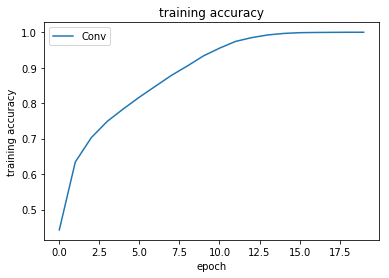

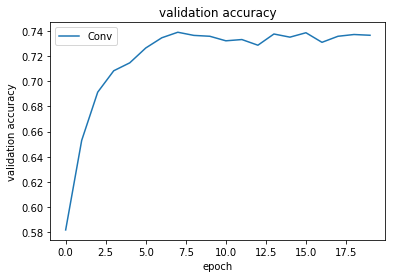

10000/10000 [==============================] - 8s 794us/step
Test accuracy: 0.7261999845504761
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_115 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_116 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        18496     
________________________

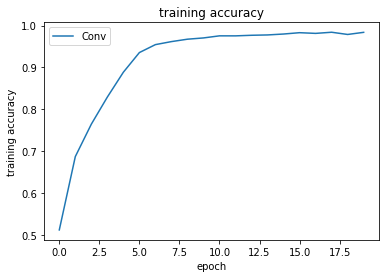

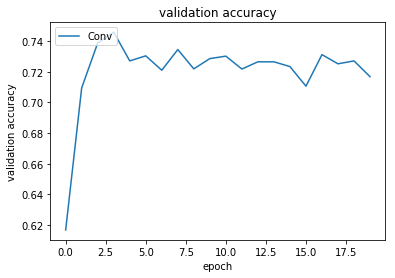

10000/10000 [==============================] - 8s 819us/step
Test accuracy: 0.7293000221252441
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_121 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_122 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 16, 16, 64)        18496     
________________________

In [31]:
#Part 4 - comparison of different optimiziers
#1st model with adagrad
model9 = Sequential()
model9.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model9.add(Activation('relu'))
model9.add(Conv2D(32, (3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling2D(pool_size=(2, 2)))
model9.add(Conv2D(64, (3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(Conv2D(64, (3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling2D(pool_size=(2, 2)))
model9.add(Flatten())
model9.add(Dense(512))
model9.add(Activation('relu'))
model9.add(Dense(num_classes))
model9.add(Activation('softmax'))

# initiate Adagrad optimizer
opt = keras.optimizers.Adagrad()
model9.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc9, val9, saved9, scores9 =  resulting(model9)
print(model9.summary())

#1st model with adam
model10 = Sequential()
model10.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model10.add(Activation('relu'))
model10.add(Conv2D(32, (3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(Conv2D(64, (3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(Conv2D(64, (3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(Flatten())
model10.add(Dense(512))
model10.add(Activation('relu'))
model10.add(Dense(num_classes))
model10.add(Activation('softmax'))

# initiate Adam optimizer
opt = keras.optimizers.Adam()
model10.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc10, val10, saved10, scores10 =  resulting(model10)
print(model10.summary())

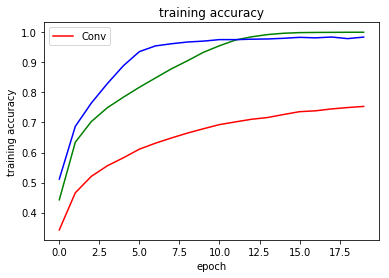

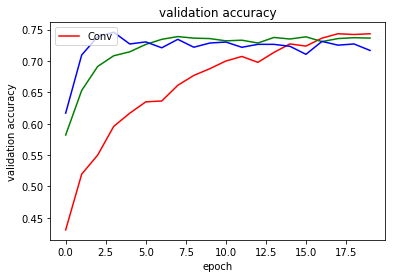

In [32]:
accs = [acc, acc9, acc10]
vals = [val, val9, val10]
cols = ["r", "g", "b"]
# Plot training accuracy
for a,i in zip(accs, range(3)): plt.plot(a, c=cols[i])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
# Plot validation accuracy
for v,j in zip(vals, range(3)): plt.plot(v, c=cols[j])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
#Red is original CNN (with RMSprop), Green is CNN with Adagrad and Blue is CNN with Adam

In this part of the assignment, we compare different optimizers presented with keras library; Adagrad and Adam. The original CNN model employs the RMSprop model and represented with red color on both graphs. The second model with green color is the modification of the original CNN with altering the optimizer to Adagrad. Third model is the blue color and the optimizer is modified to Adam. Our experiment results showed that both Adagrad and Adam optimizers perform better on the first steps of the training and learn faster than RMSprop optimizer (original CNN). At the end of 20 epochs, both optimizers reached perfect training scores while the original model was still at %70. It is clear that both Adagrad and Adam optimizers helped our models to learn quicker and perform better. This trend is similar in validation accuracy, however; at the end of 20 epochs all three optimizers performed similarly around %75 validation accuracy. The only difference is the original CNN learned slower than modified models. These results suggest that the Adagrad and Adam optimizers performed similarly on validation with RMSprop optimizer while they achieved higher training accuracy earlier than the first model. Therefore; Adagrad and Adam is a better selection for this specific example since they learn quicker and the amount of epochs are limited to 20.

**Part 5 (3 points)**: Compare the accuracy of the convolutional neural network in assignment jupyter file with a modified version that replaces each stack of (CONV2D, Activation, CONV2D, Activation) layers with 3x3 filters by a smaller stack of (CONV2D, Activation) layers with 5x5 filters. Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 2 curves (for 3x3 filters and 5x5 filters). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for as many epochs as you can up to 100 epochs.

- The two graphs for training and validation accuracy.
- For each filter configuration, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per filter configuration).
- Add some text to the Jupyter notebook to explain the results (i.e., why did one architecture perform better or worse than the other architecture).

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 67s 2ms/step - loss: 1.6230 - accuracy: 0.4216 - val_loss: 1.4519 - val_accuracy: 0.4902

Epoch 00001: val_accuracy improved from -inf to 0.49020, saving model to best_model.h5
Epoch 2/20
40000/40000 [==============================] - 70s 2ms/step - loss: 1.3237 - accuracy: 0.5294 - val_loss: 1.2979 - val_accuracy: 0.5494

Epoch 00002: val_accuracy improved from 0.49020 to 0.54940, saving model to best_model.h5
Epoch 3/20
40000/40000 [==============================] - 69s 2ms/step - loss: 1.1797 - accuracy: 0.5836 - val_loss: 1.1242 - val_accuracy: 0.6078

Epoch 00003: val_accuracy improved from 0.54940 to 0.60780, saving model to best_model.h5
Epoch 4/20
40000/40000 [==============================] - 67s 2ms/step - loss: 1.0772 - accuracy: 0.6224 - val_loss: 1.0862 - val_accuracy: 0.6223

Epoch 00004: val_accuracy improved from 0.60780 to 0.62230, sa

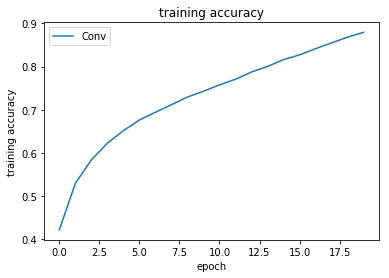

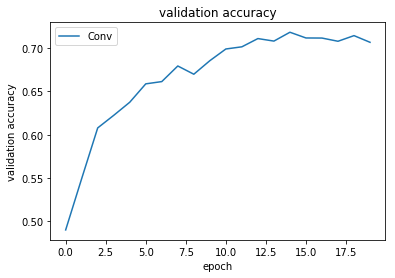

10000/10000 [==============================] - 5s 476us/step
Test accuracy: 0.7087000012397766
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_127 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
activation_128 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 8, 8, 64)          0         
________________________

In [33]:
#Part 5 - comparison on different layer structure of CNNs
model11 = Sequential()
model11.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
model11.add(Activation('relu'))
model11.add(MaxPooling2D(pool_size=(2, 2)))
model11.add(Conv2D(64, (5, 5), padding='same'))
model11.add(Activation('relu'))
model11.add(MaxPooling2D(pool_size=(2, 2)))
model11.add(Flatten())
model11.add(Dense(512))
model11.add(Activation('relu'))
model11.add(Dense(num_classes))
model11.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model11.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
acc11, val11, saved11, scores11 =  resulting(model11)
print(model11.summary())

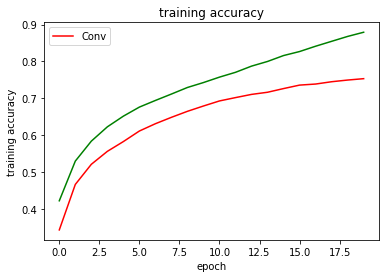

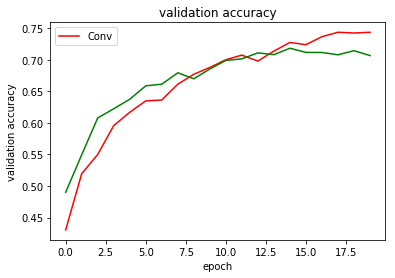

In [34]:
# Plot training accuracy
plt.plot(acc, c="r")
plt.plot(acc11, c="g")
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()
# Plot validation accuracy
plt.plot(val, c="r")
plt.plot(val11, c="g")
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

In this part of the experiment, we compare two different Convolution model structures. First model is the original CNN and the model is build with stack of (CONV2D, Activation, CONV2D, Activation) layers with 3x3 filters. In second model we replace the previously presented stack structure with a smaller stack structure (CONV2D, Activation) with 5x5 filters. First model is represented with the red color while the second model is represented with blue. Modified model performed better than original CNN, learned faster and achieved %88 training accuracy on 20 epochs while original CNN achieved %74. On validation, both models performed similarly through the 20 epochs, at the end of the runs original CNN performed with %4 higher validation accuracy. These results suggest that simpler structure with slightly larger filter size can learn faster and on validation it performs similar with a more complex model.